In [2]:
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt

In [3]:
# Problem Parameters
NBR_ITEMS = 100
MAX_WEIGHT = 1000

In [4]:
# Set random seed 
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [5]:
# Create the item dictionary: item name is an integer, and value is
# a (value, weight) 2-uple.
items = {}

# Create random items and store them in the items' dictionary.
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.randint(1, 100))

print("Knapsack Problem Setup:")
print(f"Number of items: {NBR_ITEMS}")
print(f"Maximum weight: {MAX_WEIGHT}")
print(f"Sample items: {dict(list(items.items())[:5])}")
print()

# Test different parameter combinations
test_configs = [
    (500, 100, 0.7, 0.2),  # Config 1: Standard setup
    (500, 100, 0.8, 0.3),  # Config 2: Higher crossover and mutation
]

# Store results from each test run
results = []
all_best_individuals = []

P_CROSSOVER_DEFAULT = 0.7
P_MUTATION_DEFAULT = 0.2

for config_num, (POPULATION_SIZE, MAX_GENERATIONS, P_CROSSOVER, P_MUTATION) in enumerate(test_configs, 1):
    print(f"\n{'='*70}")
    print(f"Configuration {config_num}:")
    print(f"POPULATION_SIZE={POPULATION_SIZE}, MAX_GENERATIONS={MAX_GENERATIONS}")
    print(f"P_CROSSOVER={P_CROSSOVER}, P_MUTATION={P_MUTATION}")
    print(f"{'='*70}")
    
    # Reset random seed for fair comparison
    random.seed(RANDOM_SEED)
    
    toolbox = base.Toolbox()
    
    # Create an operator that randomly returns 0 or 1
    toolbox.register("zeroOrOne", random.randint, 0, 1)
    
    # Define a single objective, maximizing fitness strategy
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    
    # Create the Individual class based on list
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    # Create the individual operator to fill up an Individual instance
    toolbox.register("individualCreator", tools.initRepeat, creator.Individual, 
                     toolbox.zeroOrOne, NBR_ITEMS)
    
    # Create the population operator to generate a list of individuals
    toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
    
    # Fitness calculation for Knapsack Problem
    def knapsackFitness(individual):
        total_value = 0
        total_weight = 0
        
        # Calculate total value and weight for selected items
        for i in range(len(individual)):
            if individual[i] == 1:
                total_value += items[i][0]  # Add value
                total_weight += items[i][1]  # Add weight
        
        # Apply penalty if weight constraint is violated
        if total_weight > MAX_WEIGHT:
            # Penalty: subtract excess weight from fitness
            # This encourages solutions to stay within weight limit
            fitness = total_value - (total_weight - MAX_WEIGHT)
        else:
            fitness = total_value
        
        return fitness,  # Return a tuple
    
    toolbox.register("evaluate", knapsackFitness)

Knapsack Problem Setup:
Number of items: 100
Maximum weight: 1000
Sample items: {0: (2, 4), 1: (5, 32), 2: (4, 18), 3: (2, 87), 4: (9, 12)}


Configuration 1:
POPULATION_SIZE=500, MAX_GENERATIONS=100
P_CROSSOVER=0.7, P_MUTATION=0.2

Configuration 2:
POPULATION_SIZE=500, MAX_GENERATIONS=100
P_CROSSOVER=0.8, P_MUTATION=0.3


c:\Users\awwal\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\awwal\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [11]:

    
    # Genetic operators
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", tools.cxTwoPoint)  # Two-point crossover
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/NBR_ITEMS)
    
    # Create initial population (generation 0)
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    generationCounter = 0
    
    # Calculate fitness tuple for each individual in the population
    fitnessValues = list(map(toolbox.evaluate, population))
    for individual, fitnessValue in zip(population, fitnessValues):
        individual.fitness.values = fitnessValue
    
    # Extract fitness values from all individuals in population
    fitnessValues = [individual.fitness.values[0] for individual in population]
    
    # Initialize statistics accumulators
    maxFitnessValues = []
    meanFitnessValues = []
    
    # Track best individual ever found
    best_ever_fitness = max(fitnessValues)
    best_ever_individual = None
    best_ever_generation = 0
    
    # Main evolutionary loop
    while generationCounter < MAX_GENERATIONS:
        # Update counter
        generationCounter = generationCounter + 1
        
        # Apply the selection operator
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        
        # Apply crossover operator to pairs of offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < P_CROSSOVER:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Apply mutation operator
        for mutant in offspring:
            if random.random() < P_MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Calculate fitness for individuals with no previous calculated fitness value
        freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
        freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
        for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
            individual.fitness.values = fitnessValue
        
        # Replace the current population with the offspring
        population[:] = offspring
        
        # Collect fitness values into a list, update statistics
        fitnessValues = [ind.fitness.values[0] for ind in population]
        
        maxFitness = max(fitnessValues)
        meanFitness = sum(fitnessValues) / len(population)
        maxFitnessValues.append(maxFitness)
        meanFitnessValues.append(meanFitness)
        
        # Track best ever individual
        if maxFitness > best_ever_fitness:
            best_ever_fitness = maxFitness
            best_index = fitnessValues.index(maxFitness)
            best_ever_individual = population[best_index][:]
            best_ever_generation = generationCounter
        
        # Print every 10 generations
        if generationCounter % 10 == 0 or generationCounter == MAX_GENERATIONS:
            print(f"Gen {generationCounter}: Max Fitness = {maxFitness:.2f}, Avg Fitness = {meanFitness:.2f}")
    
    # Calculate weight and value for best individual
    best_value = 0
    best_weight = 0
    selected_items = []
    
    for i in range(len(best_ever_individual)):
        if best_ever_individual[i] == 1:
            best_value += items[i][0]
            best_weight += items[i][1]
            selected_items.append(i)
    
    print(f"\n*** Best Solution Found in Generation {best_ever_generation}")
    print(f"*** Best Fitness: {best_ever_fitness:.2f}")
    print(f"*** Total Value: {best_value}")
    print(f"*** Total Weight: {best_weight} / {MAX_WEIGHT}")
    print(f"*** Number of items selected: {len(selected_items)}")
    print(f"*** Weight constraint satisfied: {best_weight <= MAX_WEIGHT}")
    

Gen 10: Max Fitness = 183.00, Avg Fitness = 117.22
Gen 20: Max Fitness = 230.00, Avg Fitness = 195.54
Gen 30: Max Fitness = 259.00, Avg Fitness = 230.63
Gen 40: Max Fitness = 275.00, Avg Fitness = 248.62
Gen 50: Max Fitness = 275.00, Avg Fitness = 267.34
Gen 60: Max Fitness = 275.00, Avg Fitness = 263.50
Gen 70: Max Fitness = 275.00, Avg Fitness = 265.14
Gen 80: Max Fitness = 275.00, Avg Fitness = 265.14
Gen 90: Max Fitness = 275.00, Avg Fitness = 264.35
Gen 100: Max Fitness = 275.00, Avg Fitness = 261.63

*** Best Solution Found in Generation 40
*** Best Fitness: 275.00
*** Total Value: 275
*** Total Weight: 999 / 1000
*** Number of items selected: 38
*** Weight constraint satisfied: True


In [15]:

    # Store results
    results.append({
        'config': config_num,
        'population': POPULATION_SIZE,
        'generations': MAX_GENERATIONS,
        'crossover': P_CROSSOVER,
        'mutation': P_MUTATION,
        'best_fitness': best_ever_fitness,
        'best_value': best_value,
        'best_weight': best_weight,
        'best_individual': best_ever_individual,
        'max_fitness_values': maxFitnessValues,
        'mean_fitness_values': meanFitnessValues
    })
    
    all_best_individuals.append((config_num, best_ever_fitness, best_value, best_weight, best_ever_individual))

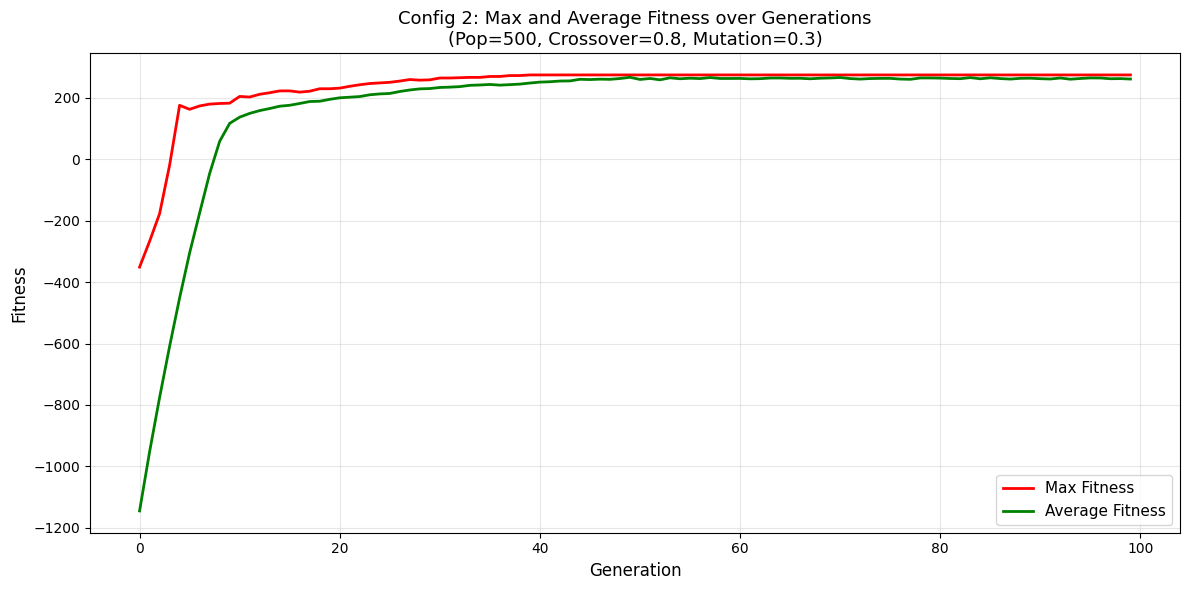

In [16]:

    
    # Plot for this configuration
    plt.figure(figsize=(12, 6))
    plt.plot(maxFitnessValues, color='red', linewidth=2, label='Max Fitness')
    plt.plot(meanFitnessValues, color='green', linewidth=2, label='Average Fitness')
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness', fontsize=12)
    plt.title(f'Config {config_num}: Max and Average Fitness over Generations\n' +
              f'(Pop={POPULATION_SIZE}, Crossover={P_CROSSOVER}, Mutation={P_MUTATION})',
              fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [10]:


# Summary table
print("\nSummary of Results:")
print("-" * 90)
print(f"{'Config':<8} {'Pop':<6} {'P_cross':<9} {'P_mut':<7} {'Best Fit':<10} {'Value':<7} {'Weight':<8} {'Valid':<6}")
print("-" * 90)
for result in results:
    valid = "Yes" if result['best_weight'] <= MAX_WEIGHT else "No"
    print(f"{result['config']:<8} {result['population']:<6} {result['crossover']:<9.2f} " +
          f"{result['mutation']:<7.2f} {result['best_fitness']:<10.2f} {result['best_value']:<7} " +
          f"{result['best_weight']:<8} {valid:<6}")
print("-" * 90)

# Find and display the overall best solution
best_result = max(results, key=lambda x: x['best_fitness'])
print(f"\n*** OVERALL BEST SOLUTION ***")
print(f"Configuration: {best_result['config']}")
print(f"Best Fitness: {best_result['best_fitness']:.2f}")
print(f"Total Value: {best_result['best_value']}")
print(f"Total Weight: {best_result['best_weight']} / {MAX_WEIGHT}")
print(f"Constraint Satisfied: {best_result['best_weight'] <= MAX_WEIGHT}")


Summary of Results:
------------------------------------------------------------------------------------------
Config   Pop    P_cross   P_mut   Best Fit   Value   Weight   Valid 
------------------------------------------------------------------------------------------
2        500    0.80      0.30    275.00     275     999      Yes   
------------------------------------------------------------------------------------------

*** OVERALL BEST SOLUTION ***
Configuration: 2
Best Fitness: 275.00
Total Value: 275
Total Weight: 999 / 1000
Constraint Satisfied: True
